# Outliers & Univariate EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
import skimage.io
import wordcloud
%matplotlib inline

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

conn_str = f'postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}'
engine = create_engine(conn_str)

query = """
SELECT *
FROM youtube
"""                       
                       
youtube_df = pd.read_sql_query(query, con=engine)
engine.dispose()
youtube_df.head()

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views
0,1st,A++,Zee TV,82757,18752951,20869786591
1,2nd,A++,T-Series,12661,61196302,47548839843
2,3rd,A++,Cocomelon - Nursery Rhymes,373,19238251,9793305082
3,4th,A++,SET India,27323,31180559,22675948293
4,5th,A++,WWE,36756,32852346,26273668433


## Identifying Outliers

### Eyeballing

We can just try and look through the data to see outliers... This doesn't work too well...

In this data we have a huge range of values, from just seeing the head and the tail we can't tell if the high numbers are outliers, the low numbers are outliers, or if it smoothly covers the full range.

### Visualization

A better way would be to use one of the distribution visualizations we know.

### Cutoff values

#### Z scores

To be a little more formal we could look into calculating $z$ scores for our observations.

The `scipy.stats` module has a function for calculating this, but there's also a custom implementation below to see what's actually being done.  In english, the formula is, for each observation, subtract the mean and divide by the standard deviation.  Intuitively, a $z$ score tells you how many standard deviations from the mean each observation is.

##### By 'hand' example

In [4]:
sample = np.array([1, 2, 3, 4, 5, 6, 25])

mean = ____
std = ____
z_scores = ____

z_scores

The mean is 6.57 & the std dev is 7.69
The largest z-score is 2.40 the corresponding value is 25.

Since our z-score is just a measure of how far each observation is from the mean, we can recalculate the original values from the zcores, mean, and std.
mean + z_score * std = 6.57 + 2.40 * 7.69 = 25.0


##### Using functions

So we can calculate these scores; so what?  With the scores, you can decide on a threshold that indicates just how far you want your data to go.  There's no perfect rule-of-thumb value.  If using this method, try some values and see how it affects your data (i.e. cuts out too much of the data as outliers? not enough?)

In [ ]:
# Function to calculate z score


In [1]:
# Calculate z score with scipy.stats
scipy_z = ____(youtube_df['Video views'])

# Calculate z score with custom function
homebrew_z = ____(youtube_df['Video views'])


# View the first 5 elements of each z score output to see differences
____

# Officially test that we're in the same ball park for scores
np.allclose(scipy_z, homebrew_z, atol=0.003)

NameError: name '____' is not defined

#### IQR

The interquartile range can also be used with some thresholding to decide whats an outlier.  This is how boxplots typically decide which points are outliers.  See reading for more...

### Handling outliers

Before you do anything about outliers you want to be intimately familiar with the data.  Why are there outliers? are they valid? do the outliers affect the analysis? how?

Let's say we're trying to predict the amount someone will spend on dinner. To do this, we have a database of their dinner spending for the past year - 1 entry for each day of the year.  In our data, we see 1 outlier that has a really large dinner cost.  We decide to drop it from our dataset and we have our model predict the next year's dinner costs.  We see that are model performed well except for 1 day where we underpredicted, and it turns out to be the same date as last year's outlier that was dropped.  In this example, maybe the day is our subject's birthday, and if we took this feature into account, maybe we could have actively predicted the cost.

This is, of course, a contrived example.  You need to weigh the costs/benefits of dropping/modifying outliers in light of your goals for the project.

Quote from John Tukey (super smart/influential stats guy):

> Sets of observations which have been de-tailed by over-vigorous use of a rule for rejecting outliers are inappropriate, since they are not samples.

Quote from Francis Bacon (maybe quote.. maybe paraphrase.. can't find good source)

> We learn once when we establish the general rule, and learn again when we investigate the exceptions.

#### Strategies covered in the reading

* Drop outliers (know the impact of the info you're removing before doing so)
* Winsorization (know the impact of the info you're adjusting before doing so)
* Transformation (keeps all information/observations)

#### Example

Let's start by exploring 2 common transformations for data.  We can apply them and then plot them to see how they affect the distribution.

In [2]:
log_views = ____(youtube_df['Video views'])
sqrt_views = ____(youtube_df['Video views'])

NameError: name '____' is not defined

Create plots for the transformed variables.  Which is the most normal?

It's important to remember you're not limited to a single strategy.  It looks like we're almost normal with the log transform.  We have a little left skew, we could see what dropping extreme outliers with a z-score method might do.  We'll use a fairly conservative cutoff value of 3.

Our results show that we only lose 19 of our 5000 observations; this removal rate of 0.3% is not bad at all, especially since our data is now normal for most intents and purposes.

There were 19 observations removed by z-score.


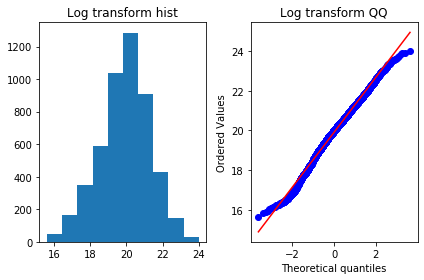

In [12]:
z_scores = stats.zscore(log_views)
outlier_filter = np.where(abs(z_scores) <= 3)


filtered_log_views = log_views.values[outlier_filter]

# Show count of lost observations
print(f'There were {len(log_views) - len(filtered_log_views)} observations removed by z-score.')

# Re-check histogram and normal QQ plot
fig, axes = plt.subplots(1, 2)

axes[0].hist(filtered_log_views)
stats.probplot(filtered_log_views, dist='norm', plot=axes[1])

axes[0].set_title('Log transform hist')
axes[1].set_title('Log transform QQ')

fig.tight_layout()
plt.show()

Okay, we transformed a variable to be more normal, so what?

* Create a scatter plot of 'Video views' & 'Video Uploads' before transformation.

* Log transform both and then remake the same scatter plot

A negative of transforms is that their less intuitive to think about and interpret.  If we built a linear model to predict views given the number of uploads, we might discover that for every 10 uploads we expect 5 views.  However, if we've done log transforms to our data we lose a little bit of this interpretability; interpreting these types of models is [still doable](https://stats.stackexchange.com/a/18639/102646), but definitely less intuitive.  You need to weigh the pros/cons of the accuracy/interpretability trade-off when making modeling decisions.

## Further EDA

What grades occurred the most? Which the least?  The reading uses `pandas` plot methods.  Lets use `sns.countplot` here for some diversity.

Let's say we wanted to order the bars so that they go from highest to lowest grade. We could try to use the `order` argument... We see though that it fails... Why?

Let's look at what values the `'Grade'` column holds just to make sure we copied them down correctly.  

We see that we have some trailing whitespace, and a weird `\xa0` that wasn't showing up in our plot at all, but rather showing as blank.  A quick google of '\xa0' leads us to find out that `\xa0` is a non-breaking space in the Latin1 encoding.  You could do more research on what that is.

Every value has some trailing whitespace, and personally, I'd like to remove that and then view the output and go from there.  We can remove leading/trailing whitespace from a `pandas.Series` using `pandas.Series.str.strip()` like below.

The output shows that the non-breaking space was also handled by `strip()` so we don't have to worry about it.

We can now apply this stripping to the column and get back to plotting.

Below is just to show that the `wordcloud` package can produce prettier wordclouds than what was shown in the reading.  Remember that prettiness doesn't really factor into EDA though; save prettiness for presentations/reports/etc.

mask shape: (512, 512, 4)


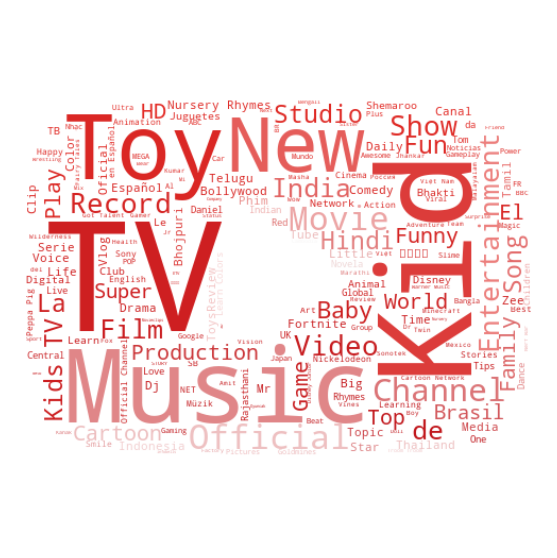

In [64]:
# Create text that will be analyzed
channel_name_text = " ".join(youtube_df["Channel name"])

# Download youtube logo to format wordcloud shape/color
# The mask will be a 3d numpy array: (height, width, [RGBA]); where RGBA = Red Green Blue Alpha
# The first 3 channels are RGB.  Black in RGB is (0, 0, 0); white is (255, 255, 255)
# The fourth channel is Alpha (aka Transparency).  0 is opaque; 255 is transparent.
mask = skimage.io.imread('https://seeklogo.net/wp-content/uploads/2016/06/YouTube-icon.png')
print(f'mask shape: {mask.shape}')

# After inspection we notice that alot of pixels have value (0, 0, 0, 0); aka opaque black
# We'd like these pixels to be transparent.  
# An easy way to do this is to set all these pixels to (255, 255, 255, 255); aka transparent white
mask[np.where(mask == [0, 0, 0, 0])] = 255

# Pass mask to WordCloud to shape our outputted plot
channel_wordcloud = wordcloud.WordCloud(background_color='white',
                                        mask=mask).generate(channel_name_text)

# Use mask and ImageColorGenerator to color our outputted plot
color_gen = wordcloud.ImageColorGenerator(mask)
channel_wordcloud = channel_wordcloud.recolor(color_func=color_gen)

plt.figure(figsize=(20,10))
plt.imshow(channel_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()